# Table of Contents
 <p>

US tornado data https://www.spc.noaa.gov/wcm/#data

In [106]:
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geographiclib.geodesic import Geodesic
from pprint import pprint
import folium
from folium.plugins import BeautifyIcon
geod = Geodesic.WGS84

pd.options.display.max_columns = 100

def miles_to_metres(miles):
    return 1e3 * miles / 0.621371

# Distance between two lat/lng coordinates in km using the Haversine formula
# Copyright 2016, Chris Youderian, SimpleMaps, http://simplemaps.com/resources/location-distance
# Released under MIT license - https://opensource.org/licenses/MIT
def earth_distance(lat1, lng1, lat2, lng2, miles=False): # use decimal degrees
    r=6371 # radius of the earth in km
    lat1=radians(lat1)
    lat2=radians(lat2)
    lat_dif=lat2-lat1
    lng_dif=radians(lng2-lng1)
    a=sin(lat_dif/2.0)**2+cos(lat1)*cos(lat2)*sin(lng_dif/2.0)**2
    d=2*r*asin(sqrt(a))
    if miles:
        return d * 0.621371 # return miles
    else:
        return d # return km

def tornado_area(slat, slon, elat, elon, tornado_width_m):
    g = geod.Inverse(slat, slon, elat, elon)
    tornado_azimuth = g['azi1']
    g1 = geod.Direct(slat, slon, tornado_azimuth + 90, tornado_width_m / 2)
    p1 = (g1['lat2'], g1['lon2'])
    g1 = geod.Direct(slat, slon, tornado_azimuth - 90, tornado_width_m / 2)
    p4 = (g1['lat2'], g1['lon2'])
    g1 = geod.Direct(elat, elon, tornado_azimuth + 90, tornado_width_m / 2)
    p2 = (g1['lat2'], g1['lon2'])
    g1 = geod.Direct(elat, elon, tornado_azimuth - 90, tornado_width_m / 2)
    p3 = (g1['lat2'], g1['lon2'])
    area = Polygon([p1, p2, p3, p4])
    return area

In [2]:
%matplotlib inline

fscale table from http://www.tornadoproject.com/cellar/fscale.htm

In [3]:
fscale = pd.read_csv('data/fujita.csv', index_col='fscale')

fscale

intensity  wspeed_mph_low  wspeed_mph_high  \
fscale                                                   
0                Gale              40               72   
1            Moderate              73              112   
2         Significant             113              157   
3              Severe             158              206   
4         Devastating             207              260   
5          Incredible             261              318   
6       Inconceivable             319              379   

                                                   damage  
fscale                                                     
0       Some damage to chimneys; breaks branches off t...  
1       The lower limit is the beginning of hurricane ...  
2       Considerable damage. Roofs torn off frame hous...  
3       Roof and some walls torn off well constructed ...  
4       Well-constructed houses leveled; structures wi...  
5       Strong frame houses lifted off foundations and...  
6       These winds are very unlikely. The small area ...

In [4]:
t2017 = pd.read_csv('data/2017_torn.csv')

In [73]:
t = t2017[['date', 'time', 'st', 'mag', 'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len', 'wid']]
t.insert(len(t.columns), 'len_m', t.len * 1.60934 * 1e3)
t.insert(len(t.columns), 'wid_m', t.wid * 0.9144)
t.insert(0, 'ts', pd.to_datetime(t.date.str.cat(others=t.time, sep=' ')).dt.tz_localize('US/Central'))
t = t.drop(['date', 'time', 'len', 'wid'], axis=1)
t = t.sort_values('ts')
t.sample(5)

ts  st  mag  inj  fat   loss  closs     slat  \
1171 2017-08-03 17:10:00-05:00  MN    0    0    0      0      0  47.3999   
1212 2017-08-18 15:40:00-05:00  FL    0    0    0      0      0  27.7150   
1339 2017-10-01 17:57:00-05:00  KS    0    0    0      0      0  39.5499   
743  2017-05-17 15:29:00-05:00  MN    0    0    0  10000      0  44.1631   
1456 2017-11-18 17:04:00-06:00  TN    0    0    0  25000      0  36.4100   

         slon     elat     elon       len_m    wid_m  
1171 -94.2862  47.3994 -94.2842    160.9340   18.288  
1212 -80.6857  27.7158 -80.6829    289.6812   18.288  
1339 -99.4754  39.5499 -99.4754     16.0934   13.716  
743  -92.1789  44.1678 -92.1684   1271.3786   27.432  
1456 -86.2600  36.4200 -86.1300  11104.4460  114.300

In [74]:
t.groupby('mag').agg(
    {'ts': 'count', 
     'len_m': ('min', 'median', 'mean', 'max', 'std'), 
     'wid_m': ('min', 'median', 'mean', 'max', 'std'), 
     'inj': ('mean', 'max'),
     'fat': ('mean', 'max'),
     'loss': ('mean', 'max'), 
     'closs': ('mean', 'max')})

ts       len_m                                                       \
    count         min      median          mean          max           std   
mag                                                                          
-9     64     16.0934    885.1370   2110.749994   37401.0616   4826.665255   
 0    640      0.0000   1110.4446   2681.889672   28742.8124   3898.904220   
 1    605     16.0934   4473.9652   6559.058025   60092.7556   6584.995320   
 2    146    241.4010  11651.6216  15227.001890   62313.6448  13037.794134   
 3     16   5713.1570  41279.5710  46914.272675  132818.8302  35948.096655   
 4      3  27986.4226  34472.0628  49503.298400   86051.4098  31817.278598   

         wid_m                                                     inj      \
           min   median         mean        max         std       mean max   
mag                                                                          
-9      0.9144    45.72    49.463325   365.7600   61.505053   0.000000   0   
 0      0.0000    45.72    71.961851  1051.5600   80.240727   0.010937   3   
 1      9.1440   137.16   219.924536  2253.0816  255.088707   0.089256  10   
 2     22.8600   320.04   451.820071  2059.2288  390.348168   0.821918  30   
 3    274.3200   594.36   801.014400  2011.6800  552.117920  19.187500  88   
 4   1005.8400  1005.84  1207.008000  1609.3440  348.433197  16.333333  25   

          fat              loss                    closs           
         mean max          mean        max          mean      max  
mag                                                                
-9   0.000000   0  0.000000e+00          0      0.000000        0  
 0   0.000000   0  2.787922e+04    4000000    251.562500    60000  
 1   0.006612   2  1.226281e+05    7270000  16310.743802  7500000  
 2   0.013699   1  1.353997e+06   50000000  47143.835616  2000000  
 3   1.687500  11  2.220675e+07  310300000  49343.750000   749500  
 4   1.333333   2  8.000000e+06   14800000  96666.666667   290000

In [75]:
t[t.mag >= 3]

ts  st  mag  inj  fat       loss   closs     slat  \
54  2017-01-21 03:35:00-06:00  MS    3   57    4    9460000  749500  31.1855   
116 2017-01-22 02:29:00-06:00  GA    3   45   11    2500000       0  30.9998   
128 2017-01-22 14:15:00-06:00  GA    3   88    5  310300000       0  31.4373   
143 2017-02-07 11:12:00-06:00  LA    3   33    0          0       0  30.0105   
144 2017-02-07 11:50:00-06:00  LA    3    3    0          0       0  30.6210   
181 2017-02-28 16:41:00-06:00  IL    3   14    2          0       0  41.3239   
188 2017-02-28 17:26:00-06:00  IL    3    0    0    2000000       0  40.9128   
195 2017-02-28 19:51:00-06:00  MO    4   12    1    8000000       0  37.7238   
194 2017-02-28 19:51:00-06:00  MO    4   12    1   14800000       0  37.7238   
196 2017-02-28 20:12:00-06:00  IL    3    0    0    6800000       0  37.8222   
203 2017-02-28 21:55:00-06:00  IL    3    2    1    5700000       0  38.1370   
204 2017-02-28 21:55:00-06:00  IL    3    1    1    2000000       0  38.1370   
205 2017-02-28 22:08:00-06:00  IN    3    1    0    3700000       0  38.1797   
277 2017-03-06 20:11:00-06:00  MO    3   12    0          0       0  38.9590   
528 2017-04-14 17:36:00-05:00  TX    3    0    0    1000000       0  34.5720   
579 2017-04-29 16:29:00-05:00  TX    4   25    2    1200000  290000  32.2572   
581 2017-04-29 17:08:00-05:00  TX    3   24    2     670000   40000  32.3991   
721 2017-05-16 15:42:00-05:00  WI    3   25    1   10520000       0  45.2529   
735 2017-05-16 18:59:00-05:00  KS    3    2    0     658000       0  38.1987   

         slon     elat      elon        len_m      wid_m  
54   -89.4799  31.4193  -89.0342   49986.1004   822.9600  
116  -83.5841  31.1557  -83.2095   39686.3244   640.0800  
128  -84.3447  31.9924  -83.3474  113297.5360  2011.6800  
143  -90.0000  30.0232  -89.8415   16238.2406   548.6400  
144  -90.9030  30.6261  -90.7973   10348.0562   320.0400  
181  -88.9504  41.3597  -88.7352   18507.4100   731.5200  
188  -89.3609  40.9854  -89.0363   28597.9718   548.6400  
195  -90.0055  37.8222  -89.7124   27986.4226  1005.8400  
194  -90.0055  37.9503  -89.0713   86051.4098  1005.8400  
196  -89.7124  37.9503  -89.0713   58064.9872   777.2400  
203  -88.1148  38.3175  -87.3355   71020.1742   402.3360  
204  -88.1148  38.1797  -87.9474   15385.2904   384.0480  
205  -87.9474  38.3175  -87.3355   55634.8838   402.3360  
277  -94.2394  38.9995  -93.9160   28549.6916   365.7600  
528 -102.3590  34.5305 -102.3957    5713.1570  1770.2784  
579  -96.0180  32.5528  -95.9306   34472.0628  1609.3440  
581  -95.8756  32.9540  -95.6987   63906.8914  1609.3440  
721  -92.1619  45.3916  -90.4919  132818.8302  1207.0080  
735  -99.0186  38.5460  -98.7999   42872.8176   274.3200

In [107]:
gt = gpd.GeoDataFrame(t, crs={'init': 'epsg:4326'},
                      geometry=[tornado_area(*args) for args in zip(t.slat, t.slon, t.elat, t.elon, t.wid_m)])

In [81]:
gt.sample(5)

ts  st  mag  inj  fat    loss  closs     slat  \
438  2017-04-03 10:10:00-05:00  GA    0    0    0  100000      0  32.0336   
105  2017-01-21 17:56:00-06:00  LA    2    1    0  500000      0  31.6824   
1450 2017-11-18 15:36:00-06:00  KY    0    0    0  125000      0  36.8890   
1142 2017-07-19 16:15:00-05:00  IA    0    0    0   12000   5000  43.3208   
331  2017-03-09 20:51:00-06:00  TN    2    0    0  300000      0  36.5033   

         slon     elat     elon      len_m    wid_m  \
438  -84.8361  32.0306 -84.8097  2510.5704  137.160   
105  -93.0381  31.6847 -93.0035  3283.0536  274.320   
1450 -87.1960  36.8936 -87.1842  1174.8182  137.160   
1142 -92.4509  43.3240 -92.4373  1158.7248   18.288   
331  -89.0837  36.4842 -89.0704  4618.8058  228.600   

                                               geometry  
438   POLYGON ((32.03298695517724 -84.836195912478, ...  
105   POLYGON ((31.68116673694991 -93.03798765915131...  
1450  POLYGON ((36.88844406024185 -87.19566404407686...  
1142  POLYGON ((43.32072166473946 -92.45086541297646...  
331   POLYGON ((36.5027951315348 -89.08481207455907,...

In [85]:
cities = pd.read_csv('data/uscities.csv')
cities = cities[['lat', 'lng', 'city', 'state_id', 'population', 'density', 'incorporated', 'timezone']]
gcities = gpd.GeoDataFrame(cities, crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(cities.lat, cities.lng)])

In [153]:
ti, ci = [], []
for index, row in gt[gt.mag > 1].iterrows():
    cities_in_tornado = gcities[gcities.geometry.distance(row.geometry) < 0.05]
    ti.extend([index] * len(cities_in_tornado.index))
    ci.extend(cities_in_tornado.index.values)
tornado_cities = pd.DataFrame(data={'tornado': ti, 'city': ci})

In [154]:
tornado_cities.count()

tornado    338
city       338
dtype: int64

In [160]:
us_center = (39.8283, -98.5795)
map = folium.Map(us_center, zoom_start=4)
for index, tornado in gt[gt.index.isin(tornado_cities.tornado)].iterrows():
    folium.Polygon(tornado.geometry.exterior.coords, color='orange', fill=True).add_to(map)
    num_icon = BeautifyIcon(text_color='orange', border_color='orange',
                            background_color='white', number=tornado.mag, icon_shape='marker')
    folium.Marker((tornado.slat, tornado.slon), icon=num_icon, popup=str(index)).add_to(map)
for index, city in gcities[gcities.index.isin(tornado_cities.city)].iterrows():
    folium.CircleMarker(
        location=(city.geometry.x, city.geometry.y), 
        radius=2, color='crimson', fill=False, popup=city.city + ': ' + str(city.population)).add_to(map)
map

need to link: for cities https://simplemaps.com/data/us-cities

In [136]:
albany_index = 128

t.loc[128]

ts                                  2017-01-22 14:15:00-06:00
st                                                         GA
mag                                                         3
inj                                                        88
fat                                                         5
loss                                                310300000
closs                                                       0
slat                                                  31.4373
slon                                                 -84.3447
elat                                                  31.9924
elon                                                 -83.3474
len_m                                                  113298
wid_m                                                 2011.68
geometry    POLYGON ((31.42972037180268 -84.33888679024969...
Name: 128, dtype: object

its link on wikipedia: https://en.wikipedia.org/wiki/Tornado_outbreak_of_January_21%E2%80%9323,_2017#Albany%E2%80%93Ashburn%E2%80%93Rochelle,_Georgia

In [137]:
from IPython.display import YouTubeVideo

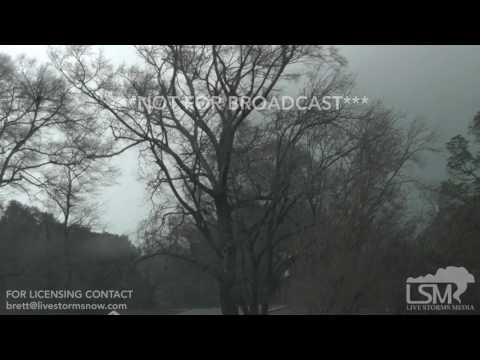

In [142]:
YouTubeVideo(id='L_I3MrC4dKg', width=800, height=600)

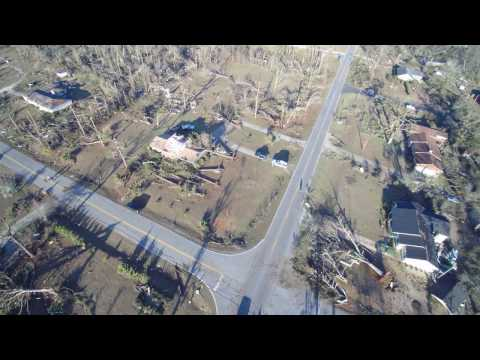

In [143]:
YouTubeVideo(id='QynQvvr4_ns', width=800, height=600)

In [162]:
gt[gt.mag >= 2].sum()

mag      3.520000e+02
inj      4.760000e+02
fat      3.300000e+01
loss     5.769915e+08
closs    7.962500e+06
slat     5.958247e+03
slon    -1.491459e+04
elat     5.970697e+03
elon    -1.488823e+04
len_m    3.122281e+06
wid_m    8.240298e+04
dtype: float64

In [163]:
5.769915e+08 + 7.962500e+06

584954000.0

In [166]:
len(tornado_cities.city.unique())

292

In [167]:
gt.loc[128]

ts                                  2017-01-22 14:15:00-06:00
st                                                         GA
mag                                                         3
inj                                                        88
fat                                                         5
loss                                                310300000
closs                                                       0
slat                                                  31.4373
slon                                                 -84.3447
elat                                                  31.9924
elon                                                 -83.3474
len_m                                                  113298
wid_m                                                 2011.68
geometry    POLYGON ((31.42972037180268 -84.33888679024969...
Name: 128, dtype: object